In [41]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt

# Airship Detection: Exploratory Data Analysis

## Overview

In this project, I aim to detect airships in satellite images. The task is challenging due to the high variability in the appearance of airships and the complex backgrounds against which they are seen.

During the initial phase of the project, I conducted a thorough review of existing solutions and approaches. One common issue I identified was the imbalance in the dataset. Specifically, there is a significant number of images that do not contain any airships, which could potentially bias my model towards predicting the absence of airships.

In the following sections of this EDA, I will delve deeper into this issue. I will inspect the dataset, verify the imbalance, and examine some of the images and their corresponding masks.

Stay tuned for more updates as I progress in my analysis and model development.


In [42]:
train_df = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')
test_df = pd.read_csv('/kaggle/input/airbus-ship-detection/sample_submission_v2.csv')

Next, I inspected the first few rows of the dataset to get a sense of the data structure. Here's what the first five rows look like:

In [43]:
train_df.head(5)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


One important observation is the presence of NaN values in the EncodedPixels column. A NaN in this column indicates that there is no airship in the corresponding image. This further confirms the earlier point about the dataset being imbalanced with a significant number of images without airships.

In [44]:
print(f'There is {train_df.ImageId.nunique()} train images')
print(f'There is {test_df.ImageId.nunique()} images in submission')

There is 192556 train images
There is 15606 images in submission


After inspecting the dataset, the next step was to preprocess the data for further analysis. One key aspect of this preprocessing was dealing with duplicate `ImageId`s in the dataset.

In the original dataset, each `ImageId` could have multiple rows with different `EncodedPixels` values. This is because each `ImageId` could correspond to multiple ships, each with its own mask represented by a unique `EncodedPixels` string.

To simplify the analysis, I combined the `EncodedPixels` values for each unique `ImageId` into a single string. This was done by grouping the DataFrame by `ImageId` and then joining the `EncodedPixels` strings. Importantly, I preserved `NaN` values in the `EncodedPixels` column for images that don't have any ships.

In [45]:
# Define a function to combine EncodedPixels
def combine_encoded_pixels(s):
    s = s.dropna()
    if s.empty:
        return np.nan
    else:
        return ' '.join(s)

# Combine EncodedPixels values for each unique ImageId
train_df = train_df.groupby('ImageId')['EncodedPixels'].apply(combine_encoded_pixels).reset_index()

In [46]:
train_df = train_df.drop_duplicates(subset=['ImageId'])

num_images_with_airships = train_df['EncodedPixels'].count()
num_images_without_airships = train_df['EncodedPixels'].isna().sum()

percentage_with_airships = (num_images_with_airships / df.shape[0]) * 100
percentage_without_airships = (num_images_without_airships / df.shape[0]) * 100

print(f"Number of images with ships: {num_images_with_airships}")
print(f"Percentage of images with ships: {percentage_with_airships:.2f}%")
print(f"Number of images without ships: {num_images_without_airships}")
print(f"Percentage of images without ships: {percentage_without_airships:.2f}%")


Number of images with ships: 42556
Percentage of images with ships: 22.10%
Number of images without ships: 150000
Percentage of images without ships: 77.90%


After preprocessing the data and combining the `EncodedPixels` values for each unique `ImageId`, I analyzed the resulting dataset.

These results confirm the earlier observation about the dataset being significantly imbalanced, with a large majority of images not containing any ships.

In light of these findings, I explored various solutions and strategies to tackle this problem. The idea that appealed to me the most involves training two separate models:

1. A **classification model** that determines whether an image contains any ships at all. This model will help us quickly identify images without ships and focus our resources on images that are likely to contain ships.

2. A **U-Net model** for image segmentation that is trained only on images containing ships. This model will be used to identify the exact location and shape of the ships in the images.

The strategy is to first use the classification model to detect if there are any ships in an image. Depending on the result, we will then use the U-Net model for image segmentation.


In [47]:
mask_only_df = train_df.dropna()

## Data Visualization

To get a better understanding of the data, I visualized some of the images and their corresponding masks. Specifically, I randomly selected 5 images that contain airships and displayed them along with their masks.

In [48]:
def preprocess_image(image_name, target_size=(224, 224)):
    # Construct full image path
    image_path = f"/kaggle/input/airbus-ship-detection/train_v2/{image_name}"  # Update the path as needed
    
    # Load image
    image = cv2.imread(image_path)
    
    # Check if image was loaded successfully
    if image is None:
        print(f"Failed to load image at {image_path}")
        return None
    
    # Convert color space from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Resize to target size
    image = cv2.resize(image, target_size)
    
    # Normalize pixel values
    image = image / 255.0
    
    return image


def rle_decode(mask_rle, shape=(768, 768), new_shape=(224, 224)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    new_shape: (height,width) of the resized array
    Returns numpy array, 1 - mask, 0 - background

    '''
    if pd.isna(mask_rle):
        # No object, create a zero-filled mask
        return np.zeros(new_shape, dtype=np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    img = img.reshape(shape).T
    img = cv2.resize(img, new_shape)
    return img.astype(np.uint8)

In [49]:
def visualize_random_image_mask(mask_only_df, num_times=5):
    for _ in range(num_times):
        # Select a random row from the dataframe
        row = mask_only_df.sample(n=1).iloc[0]

        # Get the image name and mask RLE from the row
        image_name = row['ImageId']
        mask_rle = row['EncodedPixels']

        # Preprocess the image and mask
        image = preprocess_image(image_name)
        mask = rle_decode(mask_rle)

        # Convert the image back to uint8
        image = (image * 255).astype(np.uint8)

        # Create a color mask
        color_mask = np.zeros((224, 224, 3), dtype=np.uint8)
        color_mask[mask == 1] = [255, 0, 0]  # Red for mask

        # Overlay the color mask on the image
        overlay = cv2.addWeighted(image, 0.7, color_mask, 0.3, 0)

        # Display the image, mask, and overlay
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        
        ax[0].imshow(image)
        ax[0].axis('off')
        ax[0].set_title('Image')

        ax[1].imshow(mask, cmap='gray')
        ax[1].axis('off')
        ax[1].set_title('Mask')

        ax[2].imshow(overlay)
        ax[2].axis('off')
        ax[2].set_title('Overlay')

        plt.show()



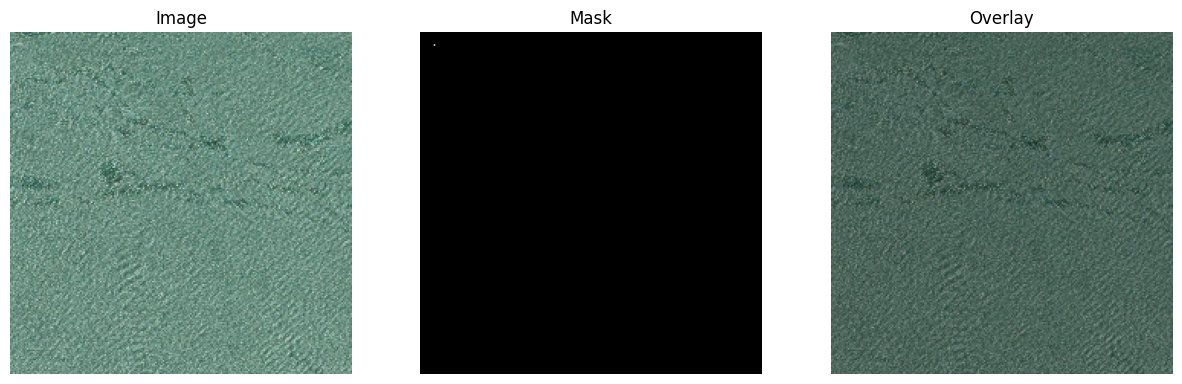

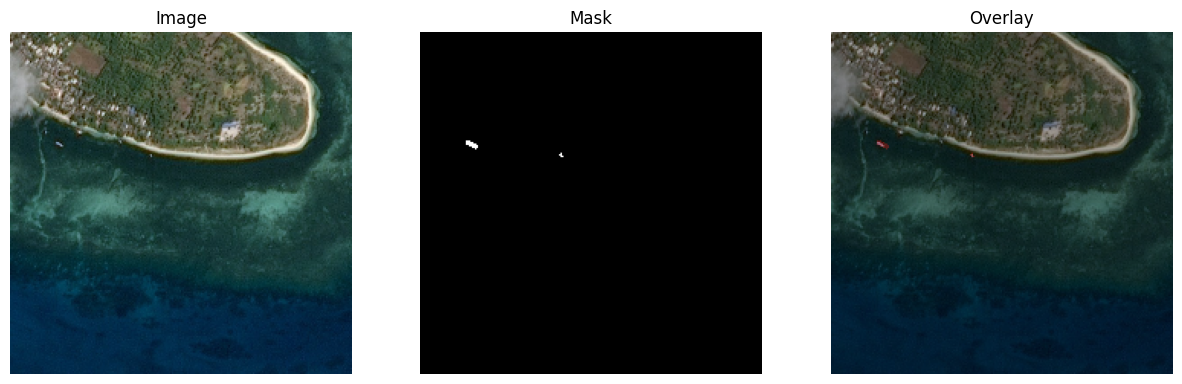

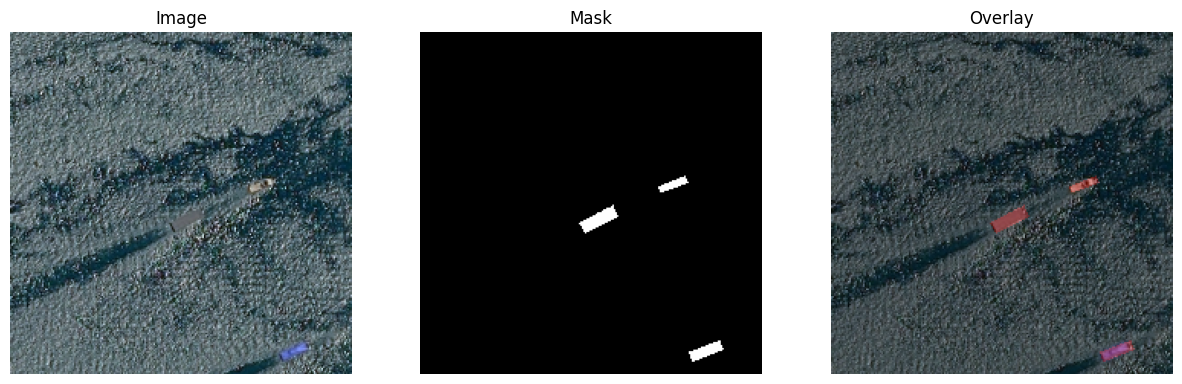

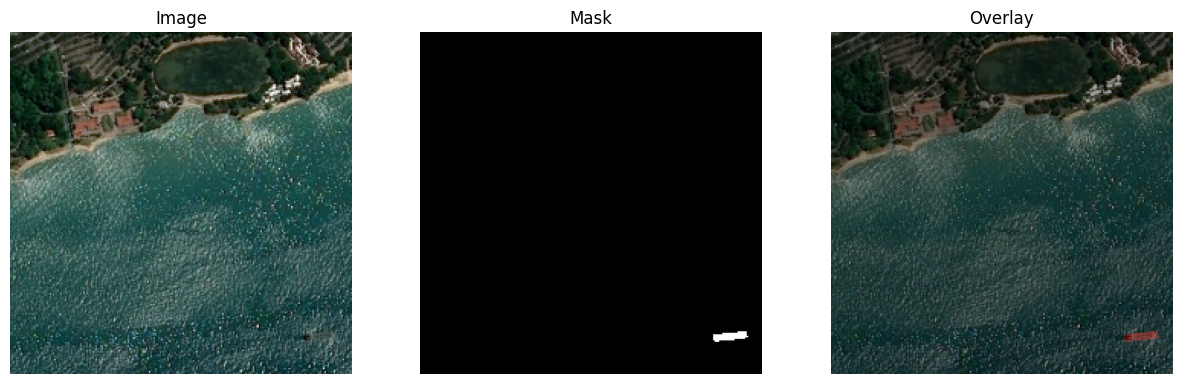

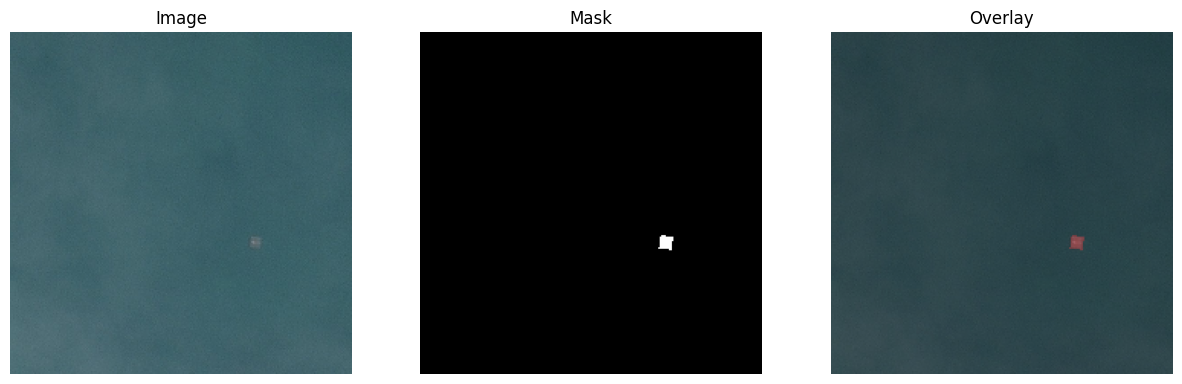

In [50]:
visualize_random_image_mask(mask_only_df)

# Airship Detection: Exploratory Data Analysis Summary

## Overview

In this project, I aimed to detect ships in satellite images. The dataset was significantly imbalanced, with a large majority of images not containing any ships. 

## Data Preprocessing

I preprocessed the data by combining the `EncodedPixels` values for each unique `ImageId` into a single string, while preserving `NaN` values for images that don't have any ships.

## Data Analysis Results and Model Strategy

The analysis of the resulting dataset confirmed the imbalance:

- Number of images with airships: 42,556 (22.10%)
- Number of images without airships: 150,000 (77.90%)

To tackle this problem, I decided to train two separate models:

1. A classification model to determine whether an image contains any ships.
2. A U-Net model for image segmentation, trained only on images containing ships.

## Data Visualization

I visualized some of the images and their corresponding masks. Specifically, I randomly selected 5 images that contain ships and displayed them along with their masks.

## Next Steps

The next steps involve implementing and training the classification and U-Net models, and evaluating their performance on the task of ship detection.
